In [3]:
#one level up into project folder
import os
#os.chdir("..")

#print("Current working directory:", os.getcwd())

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import joblib
import mlflow
import mlflow.sklearn  

from visioninfantnet.utils.ml_utils.metric.classification_metric import get_classification_score

import dagshub
dagshub.init(repo_owner='arunps12', repo_name='VisionInfantNet', mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)


Accessing as arunps12

Initialized MLflow to track repo "arunps12/VisionInfantNet"

Repository arunps12/VisionInfantNet initialized!

2025/12/06 17:06:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-pug-901 at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/afbbedaf8a584c56bae3a32d128b2b88.
2025/12/06 17:06:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


In [7]:
import os

def get_latest_artifact(root_dir="artifacts"):
    """
    Returns full path to the most recent timestamped artifact folder.
    Example folder names: '12_06_2025_14_47_14'
    """
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"{root_dir} does not exist.")

    # list subdirectories
    subdirs = [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ]

    if not subdirs:
        raise FileNotFoundError(f"No artifact folders found in {root_dir}.")

    # sort by creation time
    latest = max(subdirs, key=os.path.getmtime)
    return latest

latest_artifact_dir = get_latest_artifact()

print("Latest artifact directory:")
print(latest_artifact_dir)


Latest artifact directory:
artifacts/12_06_2025_14_47_14


In [8]:
latest_artifact_dir = get_latest_artifact()
print("Latest artifact directory:")
print(latest_artifact_dir)

Latest artifact directory:
artifacts/12_06_2025_14_47_14


In [9]:
feature_root = os.path.join(latest_artifact_dir, "data_transformation", "features")

paths = {
    "egemaps_train": f"{feature_root}/train_compare_features.npy",
    "egemaps_valid": f"{feature_root}/valid_compare_features.npy",

    "boaw_train": f"{feature_root}/train_boaw_features.npy",
    "boaw_valid": f"{feature_root}/valid_boaw_features.npy",

    "fv_train": f"{feature_root}/train_fv_features.npy",
    "fv_valid": f"{feature_root}/valid_fv_features.npy",

    "panns_train": f"{feature_root}/train_panns_features.npy",
    "panns_valid": f"{feature_root}/valid_panns_features.npy",

    "resnet_train": f"{feature_root}/train_image_embeddings.npy",
    "resnet_valid": f"{feature_root}/valid_image_embeddings.npy",

    "labels_train": f"{feature_root}/train_labels.npy",
    "labels_valid": f"{feature_root}/valid_labels.npy",
}

paths


{'egemaps_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_compare_features.npy',
 'egemaps_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_compare_features.npy',
 'boaw_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_boaw_features.npy',
 'boaw_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_boaw_features.npy',
 'fv_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_fv_features.npy',
 'fv_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_fv_features.npy',
 'panns_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_panns_features.npy',
 'panns_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_panns_features.npy',
 'resnet_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_image_embeddings.npy',
 'resnet_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/v

In [10]:
# --- Low-Level Audio Features ---
X_train_egemaps = np.load(paths["egemaps_train"])
X_valid_egemaps = np.load(paths["egemaps_valid"])

X_train_boaw = np.load(paths["boaw_train"])
X_valid_boaw = np.load(paths["boaw_valid"])

X_train_fv = np.load(paths["fv_train"])
X_valid_fv = np.load(paths["fv_valid"])

# --- Deep Audio Embeddings ---
X_train_panns = np.load(paths["panns_train"])
X_valid_panns = np.load(paths["panns_valid"])

# --- Image Embeddings ---
X_train_resnet = np.load(paths["resnet_train"])
X_valid_resnet = np.load(paths["resnet_valid"])

# --- Labels ---
y_train = np.load(paths["labels_train"])
y_valid = np.load(paths["labels_valid"])

print("Loaded all feature tensors successfully!")


Loaded all feature tensors successfully!


In [11]:
print("Shapes:")
print("eGeMAPS:", X_train_egemaps.shape, X_valid_egemaps.shape)
print("BoAW:", X_train_boaw.shape, X_valid_boaw.shape)
print("FV:", X_train_fv.shape, X_valid_fv.shape)
print("PANNs:", X_train_panns.shape, X_valid_panns.shape)
print("ResNet:", X_train_resnet.shape, X_valid_resnet.shape)
print("y_train / y_valid:", y_train.shape, y_valid.shape)

Shapes:
eGeMAPS: (3600, 88) (3580, 88)
BoAW: (3600, 1000) (3580, 1000)
FV: (3600, 640) (3580, 640)
PANNs: (3600, 2048) (3580, 2048)
ResNet: (3600, 2048) (3580, 2048)
y_train / y_valid: (3600,) (3580,)


In [12]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

print("Label encoding mapping:")
for orig, enc in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{orig} → {enc}")


#  confusion matrix plotting
def plot_confusion_matrix_local(cm, class_names, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Global imputer creator
def impute_train_valid(X_train, X_valid, strategy="median"):
    imputer = SimpleImputer(strategy=strategy)
    X_train_imp = imputer.fit_transform(X_train)
    X_valid_imp = imputer.transform(X_valid)
    return X_train_imp, X_valid_imp


Label encoding mapping:
Canonical → 0
Crying → 1
Junk → 2
Laughing → 3
Non-canonical → 4


In [16]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def resample_data(X_train, y_train_enc, method: str):
    """
    Apply class imbalance method to training data only.
    Supported:
        - none
        - class_weights
        - smote
        - smote_tomek
        - undersampling
        - smote_enn   
    """
    print(f"\n[Imbalance] Method = {method}")
    print("  Original class distribution:", Counter(y_train_enc))

    # defaults
    X_res, y_res = X_train, y_train_enc
    sample_weight = None

    # ======================================================================
    # 1. No resampling
    # ======================================================================
    if method == "none":
        return X_train, y_train_enc, None

    # ======================================================================
    # 2. Class Weights Only
    # ======================================================================
    elif method == "class_weights":
        classes = np.unique(y_train_enc)
        cw = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=y_train_enc
        )
        class_weight_dict = dict(zip(classes, cw))
        sample_weight = np.array([class_weight_dict[c] for c in y_train_enc])

        print("  Using class weights:", class_weight_dict)
        return X_train, y_train_enc, sample_weight

    # ======================================================================
    # 3. SMOTE Oversampling
    # ======================================================================
    elif method == "smote":
        try:
            sm = SMOTE(random_state=42)
            X_res, y_res = sm.fit_resample(X_train, y_train_enc)
        except ValueError as e:
            print(f"  [WARN] SMOTE failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    # ======================================================================
    # 4. SMOTE + Tomek Links 
    # ======================================================================
    elif method == "smote_tomek":
        try:
            smt = SMOTETomek(random_state=42)
            X_res, y_res = smt.fit_resample(X_train, y_train_enc)
        except ValueError as e:
            print(f"  [WARN] SMOTE-Tomek failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    # ======================================================================
    # 5. Random UnderSampling
    # ======================================================================
    elif method == "undersampling":
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X_train, y_train_enc)

    # ======================================================================
    # 6. SMOTEENN 
    # ======================================================================
    elif method == "smote_enn":
        try:
            smote_enn = SMOTEENN(random_state=42)
            X_res, y_res = smote_enn.fit_resample(X_train, y_train_enc)
        except ValueError as e:
            print(f"  [WARN] SMOTEENN failed: {e}")
            print("         Falling back to no resampling.")
            return X_train, y_train_enc, None

    else:
        raise ValueError(f"Unknown imbalance method: {method}")

    print("  New class distribution:", Counter(y_res))
    return X_res, y_res, sample_weight


In [17]:
def run_xgb_experiment_for_feature(
    feature_name: str,
    X_train_raw: np.ndarray,
    X_valid_raw: np.ndarray,
    imbalance_method: str = "none",
    n_estimators: int = 300,
    max_depth: int = 6,
    lr: float = 0.05,
):

    # 1) Impute NaNs
    X_train_imp, X_valid_imp = impute_train_valid(X_train_raw, X_valid_raw, strategy="median")

    # 2) Apply imbalance method on training set only
    X_train_bal, y_train_bal, sample_weight = resample_data(X_train_imp, y_train_enc, method=imbalance_method)

    # 3) Build XGBoost model
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=lr,
        max_depth=max_depth,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="auto",
        n_jobs=-1,
        random_state=42,
    )

    run_name = f"XGB_{feature_name}_{imbalance_method}"
    with mlflow.start_run(run_name=run_name):

        # Fit
        if imbalance_method == "class_weights" and sample_weight is not None:
            model.fit(X_train_bal, y_train_bal, sample_weight=sample_weight)
        else:
            model.fit(X_train_bal, y_train_bal)

        # Predict on validation (encoded → decode)
        y_pred_enc = model.predict(X_valid_imp)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        # Metrics
        acc = accuracy_score(y_valid, y_pred)
        metrics = get_classification_score(y_valid, y_pred)

        print(f"\n=== XGBoost on {feature_name} | imbalance={imbalance_method} ===")
        print(f"Accuracy: {acc:.4f}")
        print("Weighted F1:", metrics.f1_score)
        print("Weighted Precision:", metrics.precision_score)
        print("Weighted Recall:", metrics.recall_score)
        print("UAR:", metrics.uar)

        # Confusion matrix
        class_names = list(label_encoder.classes_)
        cm = confusion_matrix(y_valid, y_pred)
        plot_confusion_matrix_local(cm, class_names, f"XGB {feature_name} ({imbalance_method})")

        # Save confusion matrix PNG & log
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_csv = f"cm_xgb_{feature_name}_{imbalance_method}.csv"
        cm_df.to_csv(cm_csv)
        mlflow.log_artifact(cm_csv)

        cm_png = f"cm_xgb_{feature_name}_{imbalance_method}.png"
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"XGB {feature_name} ({imbalance_method})")
        plt.tight_layout()
        plt.savefig(cm_png)
        plt.close()
        mlflow.log_artifact(cm_png)

        # Log params & metrics
        mlflow.log_param("feature_type", feature_name)
        mlflow.log_param("imbalance_method", imbalance_method)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("learning_rate", lr)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", metrics.f1_score)
        mlflow.log_metric("precision", metrics.precision_score)
        mlflow.log_metric("recall", metrics.recall_score)
        mlflow.log_metric("uar", metrics.uar)

        # Save model locally and log as artifact
        os.makedirs("saved_models", exist_ok=True)
        model_path = f"saved_models/xgb_{feature_name}_{imbalance_method}.pkl"

        import pickle
        with open(model_path, "wb") as f:
            pickle.dump(model, f)

        mlflow.log_artifact(model_path, artifact_path="models")
    return acc, metrics



[Imbalance] Method = none
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})

=== XGBoost on ResNet50 | imbalance=none ===
Accuracy: 0.6360
Weighted F1: 0.5959640211867243
Weighted Precision: 0.5912369041090785
Weighted Recall: 0.6360335195530726
UAR: 0.3223388124801726


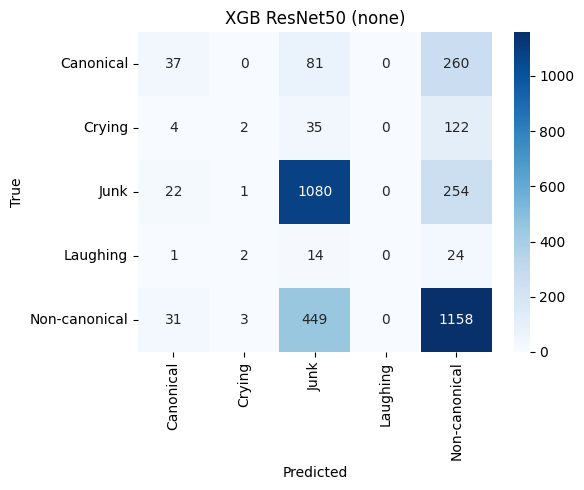

2025/12/07 10:50:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_none at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/c0f07b50ef43414bacf2d0d3ee68d7b3.
2025/12/07 10:50:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = class_weights
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  Using class weights: {np.int64(0): np.float64(1.6216216216216217), np.int64(1): np.float64(2.962962962962963), np.int64(2): np.float64(0.5034965034965035), np.int64(3): np.float64(15.652173913043478), np.int64(4): np.float64(0.5010438413361169)}

=== XGBoost on ResNet50 | imbalance=class_weights ===
Accuracy: 0.6260
Weighted F1: 0.6010381274435964
Weighted Precision: 0.5913000493053161
Weighted Recall: 0.6259776536312849
UAR: 0.3430467507337128


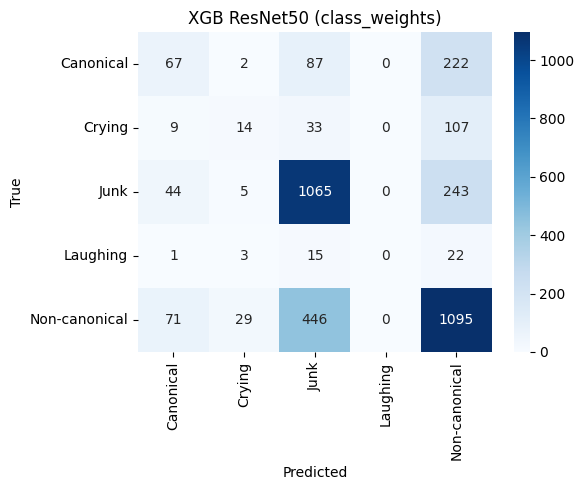

2025/12/07 10:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_class_weights at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/965803afc99d46af920e9e5c503c5153.
2025/12/07 10:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437})

=== XGBoost on ResNet50 | imbalance=smote ===
Accuracy: 0.6198
Weighted F1: 0.5950592406720401
Weighted Precision: 0.5865461043841371
Weighted Recall: 0.6198324022346369
UAR: 0.34099692345407123


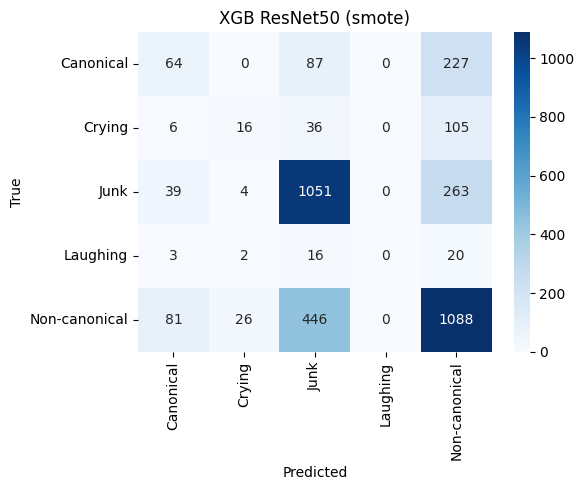

2025/12/07 10:55:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_smote at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/06757b4b3c424ba7b9cb90c098976893.
2025/12/07 10:55:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_tomek
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1437, np.int64(1): 1436, np.int64(0): 1436, np.int64(4): 1364, np.int64(2): 1362})

=== XGBoost on ResNet50 | imbalance=smote_tomek ===
Accuracy: 0.6226
Weighted F1: 0.5982197444998452
Weighted Precision: 0.5915639653262397
Weighted Recall: 0.6226256983240224
UAR: 0.34589257522922434


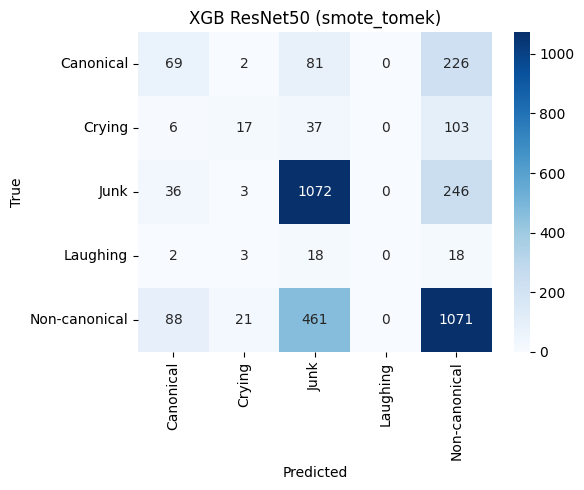

2025/12/07 10:58:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_smote_tomek at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/d588b4bd63324b9586df9665b6d94ebb.
2025/12/07 10:58:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = undersampling
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(0): 46, np.int64(1): 46, np.int64(2): 46, np.int64(3): 46, np.int64(4): 46})

=== XGBoost on ResNet50 | imbalance=undersampling ===
Accuracy: 0.3441
Weighted F1: 0.3570005753335119
Weighted Precision: 0.5285298427426218
Weighted Recall: 0.34413407821229053
UAR: 0.41792996204079447


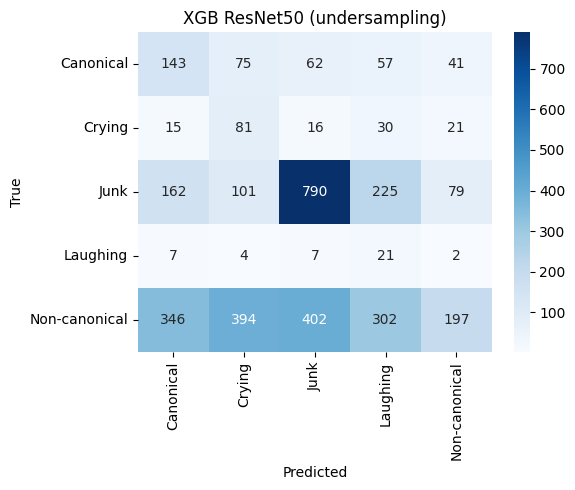

2025/12/07 10:58:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_undersampling at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/f0ed377d72d84a4bace696f7ba27e53b.
2025/12/07 10:58:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.



[Imbalance] Method = smote_enn
  Original class distribution: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
  New class distribution: Counter({np.int64(3): 1437, np.int64(1): 1406, np.int64(0): 1275, np.int64(2): 261, np.int64(4): 47})

=== XGBoost on ResNet50 | imbalance=smote_enn ===
Accuracy: 0.3170
Weighted F1: 0.28519939377636166
Weighted Precision: 0.6190174431126932
Weighted Recall: 0.3170391061452514
UAR: 0.3762598178293862


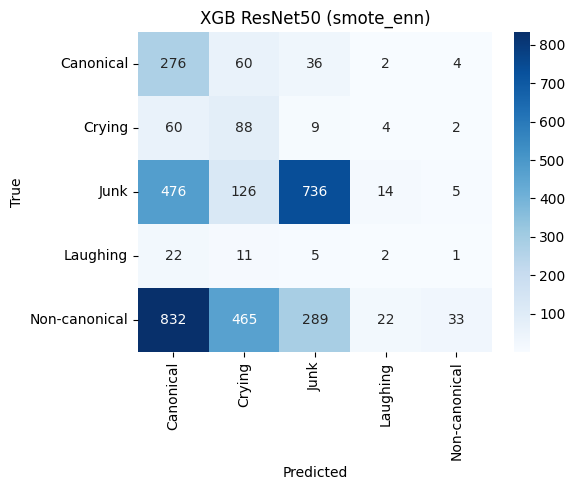

2025/12/07 11:00:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_ResNet50_smote_enn at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/5ebc85da5a2c4f1b9a61007eacce1cb7.
2025/12/07 11:00:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


,feature,imbalance_method,accuracy,f1,precision,recall,uar
0,ResNet50,none,0.636034,0.595964,0.591237,0.636034,0.322339
1,ResNet50,class_weights,0.625978,0.601038,0.591300,0.625978,0.343047
2,ResNet50,smote,0.619832,0.595059,0.586546,0.619832,0.340997
3,ResNet50,smote_tomek,0.622626,0.598220,0.591564,0.622626,0.345893
4,ResNet50,undersampling,0.344134,0.357001,0.528530,0.344134,0.417930
5,ResNet50,smote_enn,0.317039,0.285199,0.619017,0.317039,0.376260


In [20]:
feature_map = {
    #"eGeMAPS":    (X_train_egemaps, X_valid_egemaps),
    #"BoAW":       (X_train_boaw, X_valid_boaw),
    #"FisherVec":  (X_train_fv, X_valid_fv),
    #"PANNs":      (X_train_panns, X_valid_panns),
    "ResNet50":   (X_train_resnet, X_valid_resnet),
}

imbalance_methods = [
    "none",
    "class_weights",
    "smote",
    "smote_tomek",
    "undersampling",
    "smote_enn",
]

results_table = []

for feat_name, (Xtr, Xval) in feature_map.items():
    for imb in imbalance_methods:
        acc, metrics = run_xgb_experiment_for_feature(
            feature_name=feat_name,
            X_train_raw=Xtr,
            X_valid_raw=Xval,
            imbalance_method=imb,
        )
        results_table.append({
            "feature": feat_name,
            "imbalance_method": imb,
            "accuracy": acc,
            "f1": metrics.f1_score,
            "precision": metrics.precision_score,
            "recall": metrics.recall_score,
            "uar": metrics.uar,
        })

results_df = pd.DataFrame(results_table)
results_df
